In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mayurraul67","key":"5895e91c7edf937f6ef991d8be88565a"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d dansbecker/cityscapes-image-pairs

 96% 193M/202M [00:01<00:00, 106MB/s] 
100% 202M/202M [00:01<00:00, 108MB/s]


In [ ]:
! mkdir train
! unzip cityscapes-image-pairs.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: train/cityscapes_data/cityscapes_data/train/2767.jpg 

In [ ]:
import shutil
shutil.rmtree('/content/train/cityscapes_data/cityscapes_data', ignore_errors=True)

In [ ]:
def loadImages(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    
    slice_index = tf.shape(image)[1]
    slice_index = slice_index//2
    
    input_image = image[:, :slice_index, :]
    target_image = image[:, slice_index:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    
    return input_image, target_image

def resizeImages(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    target_image = tf.image.resize(target_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, target_image

IMG_HEIGHT, IMG_WIDTH = 256, 256
def random_crop(input_image, target_image):
    stacked_image = tf.stack([input_image, target_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image

def normalize_simple(input_image, target_image):
    input_image = (input_image - np.amin(input_image))/(np.amax(input_image)-np.amin(input_image))

    target_image = (target_image - np.amin(target_image))/(np.amax(target_image)-np.amin(target_image))
    
    return input_image, target_image

def random_jitter(input_image, target_image):
  # resizing to 286 x 286 x 3
    input_image, target_image = resizeImages(input_image, target_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, target_image = random_crop(input_image, target_image)
    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image

def collectImages(path):
    input_images, target_images = [], []
    for fname in os.listdir(path):
        input_image, target_image = loadImages(os.path.join(path, fname))
        input_image, target_image = random_jitter(input_image, target_image)
        input_image, target_image = normalize_simple(input_image, target_image)
        input_images.append(input_image)
        target_images.append(target_image)
        #list_of_images.append((real_image, input_image))
        
    return input_images, target_images

In [ ]:
train_path = "/content/train/cityscapes_data/train"
train_input_images, train_target_images = collectImages(train_path)

In [ ]:
test_path = "/content/train/cityscapes_data/val"
test_input_images, test_target_images = collectImages(test_path)

In [ ]:
train_input_images = tf.stack(train_input_images)
train_target_images = tf.stack(train_target_images)

In [ ]:
test_input_images = tf.stack(test_input_images)
test_target_images = tf.stack(test_target_images)

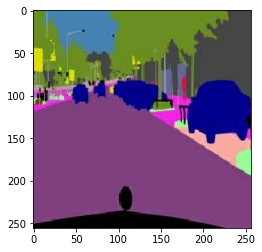

In [ ]:
plt.imshow(test_target_images[105])

In [ ]:
def downsample(filters, kernel_size=3, batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', 
                                    kernel_initializer="glorot_uniform"))
    #model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', 
                                    #kernel_initializer=initializer))    
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
        
    return model

## upsampling block
def upsample(filters, kernel_size=3, batch_norm=True, drop_out=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', 
                                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    if drop_out:
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2DTranspose(filters,3, strides = 2, padding='same'))    
    
    return model

def bottom(filters, kernel_size=3, batch_norm=True, drop_out=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', 
                                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    if drop_out:
        model.add(tf.keras.layers.Dropout(0.3))
        
    return model

def final_layer(filters_out, filters, kernel_size, batch_norm=True, drop_out=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same',
                                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    if drop_out:
        model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same',
                                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    if drop_out:
        model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(filters_out, kernel_size, padding='same',
                                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.ReLU())
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())

    return model

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.skip_list = []
        
        self.down1= downsample(64, 3)
        self.m1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down2 = downsample(128, 3)
        self.m2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down3 = downsample(256, 3)
        self.m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down4 = downsample(512, 3)
        self.m4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down5 = downsample(512, 3)
        self.m5 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down6 = downsample(512, 3)
        self.m6 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.down7 = downsample(512, 3)
        self.m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
        
        self.bottom = bottom(512, 3)
        
        self.u1 = tf.keras.layers.Conv2DTranspose(512,3, strides = 2, padding='same')
        
        self.up1 = upsample(512, 3)
        
        self.up2 = upsample(512, 3)
        
        self.up3 = upsample(512, 3)
        
        self.up4 = upsample(256, 3)
        
        self.up5 = upsample(128, 3)
        
        self.up6 = upsample(64, 3)
        
        self.final_layer = final_layer(3, 64, 3)
        
    def call_model(self):
        ## defining the input shape
        inputs = tf.keras.layers.Input(shape=[256,256,3])
        
        x = inputs
        print('input', x.shape)
        
        x = self.down1(x)
        c1 = x
        x = self.m1(x)
        print('c1', x.shape)
        
        x = self.down2(x)
        c2 = x
        x = self.m2(x)
        print('c2', x.shape)
        
        x = self.down3(x)
        c3 = x
        x = self.m3(x)
        print('c3', x.shape)
        
        x = self.down4(x)
        c4 = x
        x = self.m4(x)
        print('c4', x.shape)
        
        x = self.down5(x)
        c5 = x
        x = self.m5(x)
        print('c5', x.shape)
        
        x = self.down6(x)
        c6 = x
        x = self.m6(x)
        print('c6', x.shape)
        
        x = self.down7(x)
        c7 = x
        x = self.m7(x)
        print('c7', x.shape)
        
        x = self.bottom(x)
        print('bottom', x.shape)
        
        x = self.u1(x)
        print('u1', x.shape)
        
        x = self.up1(tf.keras.layers.concatenate([x, c7], axis=3))
        print('up1', x.shape)
        
        x = self.up2(tf.keras.layers.concatenate([x, c6], axis=3))
        print('up2', x.shape)
        
        x = self.up3(tf.keras.layers.concatenate([x, c5], axis=3))
        print('up3', x.shape)
        
        x = self.up4(tf.keras.layers.concatenate([x, c4], axis=3))
        print('up4', x.shape)
        
        x = self.up5(tf.keras.layers.concatenate([x, c3], axis=3))
        print('up5', x.shape)
        
        x = self.up6(tf.keras.layers.concatenate([x, c2], axis=3))
        print('up6', x.shape)
        
        x = self.final_layer(tf.keras.layers.concatenate([x, c1], axis=3))
        print('up7', x.shape)
        
        return tf.keras.Model(inputs=inputs, outputs=x)

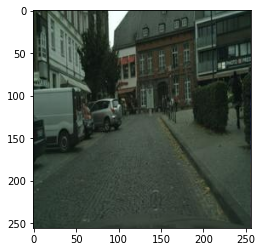

In [ ]:
path = "/content/train/cityscapes_data/train"
inp, rel = loadImages(path+'/109.jpg')
inp, rel = resizeImages(inp, rel, 256, 256)
plt.figure(0)
plt.imshow(inp/255)

input (None, 256, 256, 3)
c1 (None, 128, 128, 64)
c2 (None, 64, 64, 128)
c3 (None, 32, 32, 256)
c4 (None, 16, 16, 512)
c5 (None, 8, 8, 512)
c6 (None, 4, 4, 512)
c7 (None, 2, 2, 512)
bottom (None, 2, 2, 512)
u1 (None, 4, 4, 512)
up1 (None, 8, 8, 512)
up2 (None, 16, 16, 512)
up3 (None, 32, 32, 512)
up4 (None, 64, 64, 256)
up5 (None, 128, 128, 128)
up6 (None, 256, 256, 64)
up7 (None, 256, 256, 3)
<class 'tensorflow.python.keras.engine.training.Model'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


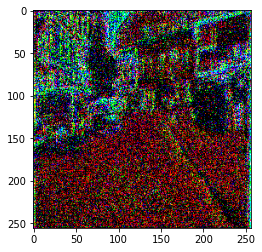

In [ ]:
generator = Generator().call_model()
print(type(generator))
gen = generator(inp[tf.newaxis, ...], training=True)
plt.imshow(gen[0])

In [ ]:
initializer = tf.random_normal_initializer(0., 0.02)

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #initializer = tf.random_normal_initializer(0., 0.02)
        self.down1 = downsample(64, 4)
        self.m1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))

        self.down2 = downsample(128, 4)
        self.m2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))

        self.down3 = downsample(256, 4)
        self.m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))

        self.zero_padding1 = tf.keras.layers.ZeroPadding2D()
        self.c1 = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                        kernel_initializer='glorot_uniform', use_bias=False)

        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()

        self.zero_padding2 = tf.keras.layers.ZeroPadding2D()
        self.c2 = tf.keras.layers.Conv2D(1, 4, strides=1,
                                        kernel_initializer='glorot_uniform')
            
    def call_model(self):
        inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
        tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

        x = tf.keras.layers.concatenate([inp, tar], axis=3)
        print(x.shape)
        y = x

        x = self.down1(x)
        x = self.m1(x)
        print(x.shape)

        x = self.down2(x)
        x = self.m2(x)
        print(x.shape)

        x = self.down3(x)
        x = self.m3(x)
        print(x.shape)
        
        x = self.zero_padding1(x)
        print(x.shape)
        x = self.c1(x)
        print(x.shape)
        x = self.batchnorm(x)
        print(x.shape)
        x = self.leaky_relu(x)
        print(x.shape)
        x = self.zero_padding2(x)
        print(x.shape)
        x = self.c2(x)
        print(x.shape)

        return tf.keras.Model(inputs=[inp, tar], outputs=x)

(None, 256, 256, 6)
(None, 128, 128, 64)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 34, 34, 256)
(None, 31, 31, 512)
(None, 31, 31, 512)
(None, 31, 31, 512)
(None, 33, 33, 512)
(None, 30, 30, 1)


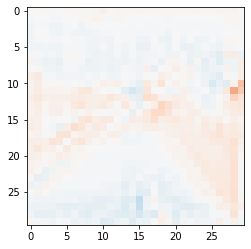

In [ ]:
discriminator = Discriminator().call_model()
#print(type(generator))
disc = discriminator([rel[tf.newaxis, ...], gen], training=True)
plt.imshow(disc[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')

In [ ]:
def generate_images(model, inp, tar):
    prediction = model(inp, training=True)
    plt.figure(figsize=(15,15))

    display_list = [inp[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


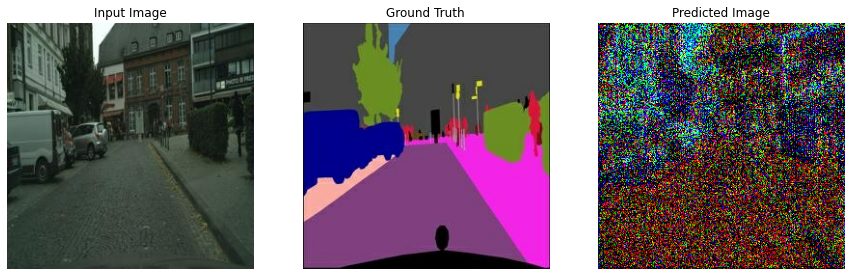

In [ ]:
x = inp[tf.newaxis, ...]/255
c = rel[tf.newaxis, ...]/255
generate_images(generator, x, c)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_gen_out, gen_out, target_image):
    gan_loss = loss_object(tf.ones_like(disc_gen_out), disc_gen_out)
    
    mae_loss = tf.reduce_mean(tf.abs(target_image - gen_out))
    
    Lambda = 100 
    
    total_gen_loss = mae_loss*Lambda + gan_loss
    
    return total_gen_loss, mae_loss, gan_loss

def discriminator_loss(disc_gen_in, disc_tar_in):
    disc_real_loss = loss_object(tf.ones_like(disc_tar_in), disc_tar_in)
    disc_gen_loss = loss_object(tf.zeros_like(disc_gen_in), disc_gen_in)
    
    total_disc_loss = disc_real_loss + disc_gen_loss
    
    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                      generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                            discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                      generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                          discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss

Start of training

start of epoch  1
......................................................................................................................................................................................................
Losses after epoch 1 :
Gen Loss: tf.Tensor(37.94058, shape=(), dtype=float32)
Disc Loss: tf.Tensor(0.12583582, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


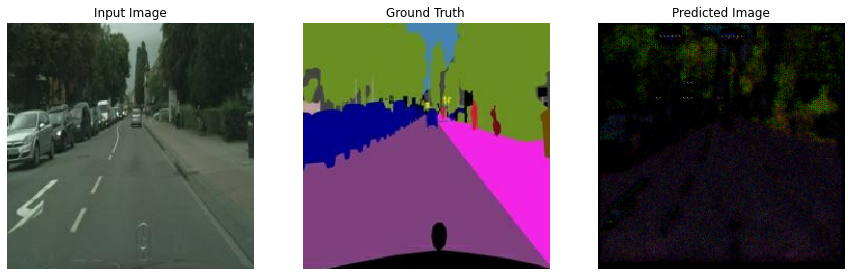

end of epoch  1

start of epoch  2
......................................................................................................................................................................................................
Losses after epoch 2 :
Gen Loss: tf.Tensor(31.327862, shape=(), dtype=float32)
Disc Loss: tf.Tensor(0.0077096866, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


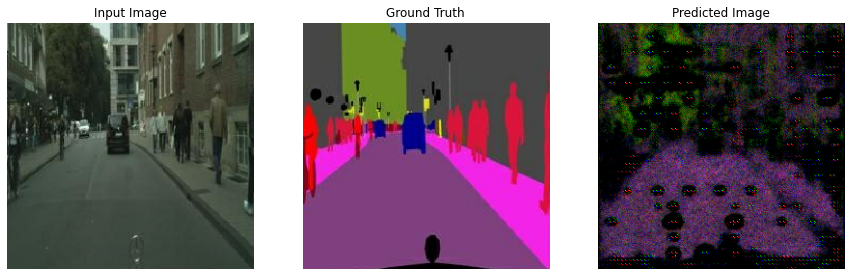

end of epoch  2

start of epoch  3
....................................................................................................................

In [ ]:
import random
batch_size = 15
num_batches = len(train_input_images)//batch_size
epochs = 100

print("Start of training")
print()
for epoch in range(epochs):
    genLosses = 0
    discLosses = 0
    print('start of epoch ',  epoch+1)
    for batch in range(num_batches):
        inp = train_input_images[batch*batch_size: (batch+1)*batch_size]
        tar = train_target_images[batch*batch_size: (batch+1)*batch_size]
        genLoss, discLoss = train_step(inp, tar)
        genLosses = genLosses + genLoss
        discLosses = discLosses + discLoss
        print('.', end='')
    print()
    print("Losses after epoch", epoch+1, ":")
    print("Gen Loss:", genLosses/num_batches)
    print("Disc Loss:", discLosses/num_batches)
    c = random.randint(0, test_target_images.shape[0])
    generate_images(generator, test_input_images[c:c+1], test_target_images[c:c+1])
    print('end of epoch ',  epoch+1)
    print()
print("end of training")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')